In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [2]:
path = r".\..\..\Datos_Proyecto"

df_observations = pd.read_csv(r".\..\..\Datos_Proyecto\observations.csv")

**CHECK FOR NA VALUES ON DATA**

In [ ]:
for csv in os.listdir(path):
    df = pd.read_csv(os.path.join(path, csv)) 
    print(f"{csv}:\n{df.isna().sum()}\n")

VISUALIZACION DE VALORES NULOS

In [ ]:
# 2. Resumen de los datos nulos
print("Resumen de valores nulos por columna:")
print(df_observations.isnull().sum())

# 3. Total de nulos
total_nulos = df_observations.isnull().sum().sum()
print(f"\nTotal de valores nulos en el DataFrame: {total_nulos}")

# 4. Porcentaje de datos nulos por columna
porcentaje_nulos = (df_observations.isnull().sum() / len(df_observations)) * 100
print("\nPorcentaje de valores nulos por columna:")
print(porcentaje_nulos)

In [ ]:
# Calcular la cantidad de valores nulos por columna
null_counts = df_observations.isnull().sum()

# Calcular el total de registros por columna
total_counts = df_observations.shape[0]

# Crear una nueva DataFrame con los datos para graficar
data = pd.DataFrame({
    'No Nulos': total_counts - null_counts.values,
    'Nulos': null_counts.values
}, index=null_counts.index)

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))

# Crear el gráfico de barras apiladas (gráfico de columnas agrupadas)
data.plot(kind='bar', stacked=False, color=['green', 'red'])

# Títulos y etiquetas
plt.title("Total de Registros vs Valores Nulos por Columna")
plt.xlabel("Columnas")
plt.ylabel("Cantidad de Registros")
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x si es necesario

# Agregar leyenda
plt.legend(["No Nulos", "Nulos"])

# Mostrar el gráfico
plt.show()

In [ ]:
# Estadísticas descriptivas de las columnas con nulos
cols_nulos = ['precipitation', 'temp_max', 'temp_min', 'wind']
print(df_observations[cols_nulos].describe())

# Histograma de cada columna
for col in cols_nulos:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_observations[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

**ANALISIS DE DATOS CON NULOS**

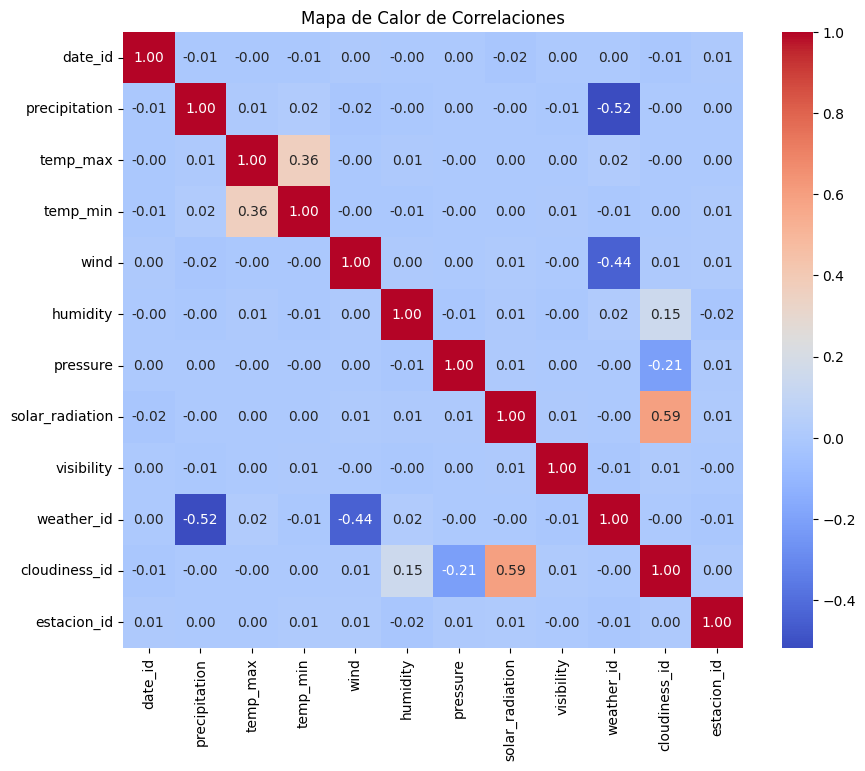

In [3]:
data = pd.read_csv(r"E:\STUCOM\Master_IABD\Projecte3_Meteorologia\Datos_Proyecto\observations.csv")

data_cleaned = data.dropna()

numerical_data = data_cleaned.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones')
plt.show()


**VISUALIZAR LOS DATOS QUE RESALTAN EN EL GRÁFICO DE CORRELACIONES**

WEATHER_ID

In [ ]:
# Boxplot de weather_id vs precipitación
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_id', y='precipitation', hue='weather_id', data=data_cleaned, palette='Blues', legend=False)
plt.title('Distribución de Precipitación según Weather ID')
plt.xlabel('Weather ID')
plt.ylabel('Precipitación')
plt.show()

# Boxplot de weather_id vs viento
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_id', y='wind', data=data_cleaned, palette='Greens')
plt.title('Distribución de Viento según Weather ID')
plt.xlabel('Weather ID')
plt.ylabel('Viento')
plt.show()

In [ ]:
# Boxplot de weather_id vs viento
plt.figure(figsize=(10, 6))
sns.boxplot(x='cloudiness_id', y='solar_radiation', data=data_cleaned, palette='Reds')
plt.title('Distribución de Radiación Solar según Cloudiness ID')
plt.xlabel('Cloudiness ID')
plt.ylabel('Radiación Solar')
plt.show()

**METODOS DE IMPUTACIÓN DE VALORES NULOS**

con los valores previos y posteriores del valor nulo

In [6]:
dates = pd.read_csv(r"D:\STUCOM\Master_IABD\Projecte3_Meteorologia\Datos_Proyecto\dates.csv")  # Archivo con las fechas

# Unir la fecha al DataFrame principal
df_observations = df_observations.merge(dates, on='date_id', how='left')

# Convertir la fecha a formato datetime y extrae
df_observations['date'] = pd.to_datetime(df_observations['date'])

# ordenar por 'date'
df_observations = df_observations.sort_values(by='date')

# Calcular las medias por estación y año para las columnas con valores nulos
columns_to_impute = ['precipitation', 'temp_max', 'temp_min', 'wind']

for col in columns_to_impute:
    df_observations[col] = df_observations[col].interpolate(method='linear', limit_direction='both')

df_observations.to_csv(r"D:\STUCOM\Master_IABD\Projecte3_Meteorologia\Datos_Proyecto\observations_full.csv", index=False)



**ANALISIS DE DATOS SIN NULOS**

In [ ]:
full_data = pd.read_csv(r"C:\Users\joant\OneDrive\Stucom\MasterIA\BigData\Projecte3_Meteorologia\Datos_Proyecto\observations_full.csv")

numerical_data = full_data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

In [ ]:
# Estadísticas descriptivas de las columnas que contenian nulos
cols_nulos = ['precipitation', 'temp_max', 'temp_min', 'wind']
print(full_data[cols_nulos].describe())

# Histograma de cada columna
for col in cols_nulos:
    plt.figure(figsize=(8, 5))
    sns.histplot(full_data[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

**VISUALIZAR LOS DATOS QUE RESALTAN EN EL GRÁFICO DE CORRELACIONES**

WEATHER ID

In [ ]:
# Boxplot de weather_id vs precipitación
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_id', y='precipitation', hue='weather_id', data=full_data, palette='Blues', legend=False)
plt.title('Distribución de Precipitación según Weather ID')
plt.xlabel('Weather ID')
plt.ylabel('Precipitación')
plt.show()

PRECIPITATION

In [ ]:
# Boxplot de weather_id vs viento
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_id', y='wind', data=full_data, palette='Greens')
plt.title('Distribución de Viento según Weather ID')
plt.xlabel('Weather ID')
plt.ylabel('Viento')
plt.show()

WEATHER ID vs WIND

In [ ]:
# Boxplot de weather_id vs viento
plt.figure(figsize=(10, 6))
sns.boxplot(x='cloudiness_id', y='solar_radiation', data=full_data, palette='Reds')
plt.title('Distribución de Radiación Solar según Cloudiness ID')
plt.xlabel('Cloudiness ID')
plt.ylabel('Radiación Solar')
plt.show()

**CARGAR LOS DATOS SQL Y CREAR LOS GRAFICOS**

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

conn = sqlite3.connect(r"C:\Users\joant\OneDrive\Stucom\MasterIA\BigData\Projecte3_Meteorologia\Entregables\Code\weather.db")

# Cargar cada tabla en un DataFrame de pandas
df_cloudiness = pd.read_sql_query("SELECT * FROM cloudiness", conn)
df_dates = pd.read_sql_query("SELECT * FROM dates", conn)
df_observations = pd.read_sql_query("SELECT * FROM observations_full", conn)
df_weather = pd.read_sql_query("SELECT * FROM weather", conn)
df_seasons = pd.read_sql_query("SELECT * FROM seasons", conn)

# Cerrar la conexión cuando hayas terminado
conn.close()

# Unir las tablas usando merge
df = df_observations \
    .merge(df_dates, on='date_id') \
    .merge(df_weather, on='weather_id') \
    .merge(df_cloudiness, on='cloudiness_id') \
    .merge(df_seasons, on='estacion_id')


DISTRIBUCIÓN DE LAS TEMPERATURAS MAXIMAS

In [ ]:
# Graficar un histograma de temperatura máxima
plt.figure(figsize=(10, 6))
sns.histplot(df['temp_max'].dropna(), bins=30, kde=True)
plt.title("Distribución de Temperatura Máxima")
plt.xlabel("Temperatura Máxima (°C)")
plt.ylabel("Frecuencia")
plt.show()

TEMPERATURA MAX/MIN POR FECHA

In [ ]:
# Convertir la columna de fechas a tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Graficar temperatura máxima y mínima a lo largo del tiempo
plt.figure(figsize=(14, 8))
sns.lineplot(x='date', y='temp_max', data=df, label='Temp Max')
sns.lineplot(x='date', y='temp_min', data=df, label='Temp Min')
plt.title("Temperatura Máxima y Mínima a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()

HUMEDAD POR CONDICION CLIMATICA

In [ ]:
# Calcular la humedad promedio por tipo de clima
df_weather_humidity = df.groupby('weather')['humidity'].mean().reset_index()

# Graficar la humedad promedio por tipo de clima
plt.figure(figsize=(10, 6))
sns.barplot(x='humidity', y='weather', hue='weather', data=df_weather_humidity, palette="viridis", legend=False)
plt.title("Humedad Promedio por Condición Climática")
plt.xlabel("Humedad (%)")
plt.ylabel("Condición Climática")
plt.show()

TEMPERATURA MÁXIMA POR TIPO DE TIEMPO

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='temp_max', hue='weather', data=df, palette="Set3", legend=False)
plt.title("Distribución de Temperatura Máxima por Condición Climática")
plt.xlabel("Condición Climática")
plt.ylabel("Temperatura Máxima (°C)")
plt.show()

VIENTO vs PRESIÓN

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind', y='pressure', hue='cloudiness', data=df, palette="bright")
plt.title("Viento vs. Presión según Nubosidad")
plt.xlabel("Velocidad del Viento (m/s)")
plt.ylabel("Presión (hPa)")
plt.legend(title="Nubosidad", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

PRECIPITACION POR VIENTO Y TIPO DE TIEMPO

In [ ]:
# Graficar
plt.figure(figsize=(12, 8))
sns.scatterplot(x='wind', y='precipitation', hue='weather', data=df, palette="Set2", s=50)
plt.title("Precipitación vs. Viento por Weather")
plt.xlabel("Velocidad del Viento (m/s)")
plt.ylabel("Precipitación (mm)")
plt.legend(title='Tipo de Tiempo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


PRECIPITACIÓN POR TIPO DE TIEMPO

In [ ]:
# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(x='weather', y='precipitation', hue='weather', data=df, palette="viridis", legend=False)
plt.title("Precipitación Promedio por Weather")
plt.xlabel("Tipo de Tiempo")
plt.ylabel("Precipitación Promedio (mm)")
plt.xticks(rotation=45)
plt.show()

TEMPERATURA PROMEDIO POR MES

In [ ]:
# CONVERTIR date A datetime
df['date'] = pd.to_datetime(df['date'])

# EXTRAER MES Y AÑO
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# AGRUPAR POR MES Y CALCULAR LA TEMPERATURA PROMEDIO
df_temp_by_month = df.groupby('month').agg({'temp_max': 'mean', 'temp_min': 'mean'}).reset_index()

# MOSTRAR GRAFICO
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_temp_by_month, x='month', y='temp_max', marker='o', label='Temp Max', color='red')
sns.lineplot(data=df_temp_by_month, x='month', y='temp_min', marker='o', label='Temp Min', color='blue')
plt.title("Temperatura Promedio por Mes")
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.xticks(ticks=df_temp_by_month['month'], labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
plt.legend()
plt.show()


TEMPERATURA PROMEDIO POR AÑO

In [ ]:
# CONVERTIR date A datetime
df['date'] = pd.to_datetime(df['date'])

# EXTRAER MES Y AÑO
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# AGRUPAR POR MES Y CALCULAR LA TEMPERATURA PROMEDIO
df_temp_by_month = df.groupby('year').agg({'temp_max': 'mean', 'temp_min': 'mean'}).reset_index()

# MOSTRAR GRAFICO
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_temp_by_month, x='year', y='temp_max', marker='o', label='Temp Max', color='red')
sns.lineplot(data=df_temp_by_month, x='year', y='temp_min', marker='o', label='Temp Min', color='blue')
plt.title("Temperatura Promedio por Año")
plt.xlabel("Year")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()


VARIABILIDAD DE LA VISIBILIDAD POR CONDICIÓN CLIMÁTICA

In [ ]:
# Grafica de la visibilidad por condición climática
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='weather', y='visibility', hue='weather_id', palette="viridis", legend=False)
plt.title('Variabilidad de la Visibilidad por Condición Climática')
plt.xlabel('Condición Climática')
plt.ylabel('Visibilidad')
plt.grid(axis='y')
plt.show()


TEMPERATURA MÁXIMA Y MÍNIMA PROMEDIO POR ESTACIÓN DEL AÑO

In [ ]:
# Temperatura promedio por estación
temp_seasonal_avg = df.groupby('estacion')[['temp_max', 'temp_min']].mean()

# Gráfica de barras para temperatura máxima y mínima por estación
plt.figure(figsize=(10, 6))
temp_seasonal_avg.plot(kind='bar', color=['#ff8f1e','#47bfff'])
plt.title('Temperatura Máxima y Mínima Promedio por Estación del Año')
plt.xlabel('Estación')
plt.xticks(ticks=range(4), labels=['Invierno', 'Primavera', 'Verano', 'Otoño'], rotation=0)
plt.ylabel('Temperatura Promedio')
plt.legend(['Temp Max', 'Temp Min'])
plt.grid(axis='y')
plt.show()
